In [2]:
import numpy as np
import pandas as pd

In [3]:
metadata_path = "/kaggle/input/kneemridataset/metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck


In [4]:
from tqdm import tqdm
import os
import pickle

all_slice_counts = []

counter = 1

patient_count = 0

for index, row in tqdm(metadata.iterrows(), total = len(metadata)):
    
    temp_file_path = "/kaggle/input/kneemridataset/vol0" + str(counter) + '/' + row['volumeFilename']
    if os.path.exists(temp_file_path) == False:
        counter += 1
        if counter > 8:
            break
        temp_file_path = "/kaggle/input/kneemridataset/vol0" + str(counter) + '/' + row['volumeFilename']
    
    with open(temp_file_path, "rb") as file:
        temp_data = pickle.load(file)
    
    if temp_data.shape[1] == temp_data.shape[2] == 320:
        patient_count +=1
    
    all_slice_counts.append(temp_data.shape[0])

 80%|████████  | 736/917 [00:53<00:13, 13.78it/s]


In [5]:
print (patient_count)

#used to be 737

731


In [7]:
minimum_slice_count = min(all_slice_counts)
print(minimum_slice_count)

21


In [9]:
#number of patients (approx 80% of this data available), depth, image width, image height
x_size = (patient_count,  minimum_slice_count, 320, 320) # for each patient we have a corresponding 3d image of size 320x320 with 21 slices
y_size = (patient_count) # 
x = np.zeros(x_size)
y = np.zeros(y_size)

In [10]:
import pickle
import os
from tqdm import tqdm

counter = 1
custom_index = 0

for index, row in tqdm(metadata.iterrows(), total = patient_count+6):
    temp_file_path = "/kaggle/input/kneemridataset/vol0" + str(counter) + "/" + row['volumeFilename']
    if os.path.exists(temp_file_path) == False:
        counter += 1
        if counter > 8:
            break
        temp_file_path = "/kaggle/input/kneemridataset/vol0" + str(counter) + "/" + row['volumeFilename']
        
    with open(temp_file_path, "rb") as file:
        temp_data = pickle.load(file)
    
    if temp_data.shape[1] == temp_data.shape[2] == 320:
        d = temp_data.shape[0]

        if d % 2 == 1:
            start_index = int(d/2) - int(minimum_slice_count-1)/2
            end_index = int(d/2) + int(minimum_slice_count-1)/2 + 1
        else:
            start_index = int((d-1)/2) - int(minimum_slice_count-1)/2
            end_index = int((d-1)/2) + int((minimum_slice_count-1)/2) + 1

        cropped_patient_data = temp_data[int(start_index):int(end_index), :, :] #21x320x320

        x[custom_index] = cropped_patient_data
        y[custom_index] = row["aclDiagnosis"]
        
        custom_index += 1

100%|█████████▉| 736/737 [00:24<00:00, 30.02it/s]


In [11]:
print(x.shape)
print(y.shape)

(731, 21, 320, 320)
(731,)


In [15]:
list_y = list(y)
print("Healthy Patient Count:" , list_y.count(0))
print("Partially Torn Patient Count:", list_y.count(1))
print("Fully Torn Patient Count:", list_y.count(2))

Healthy Patient Count: 543
Partially Torn Patient Count: 143
Fully Torn Patient Count: 45


0.0


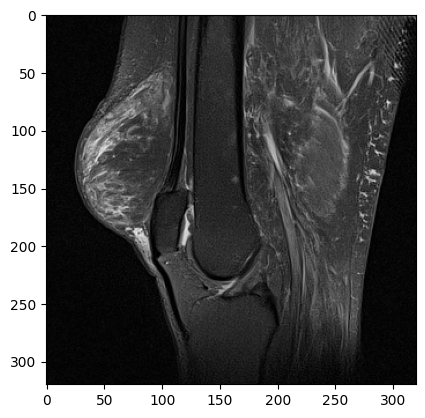

In [10]:
import matplotlib.pyplot as plt

print(y[0])

plt.imshow(x[0][10], cmap="gray")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
#converting our numpy arrays to pytorch tensor for compatible machine learning processing
x_tensor = torch.tensor(x, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

In [13]:
print (x_tensor.shape)
print (y_tensor.shape)

torch.Size([731, 21, 320, 320])
torch.Size([731])


In [14]:
x_tensor_flatenned = x_tensor.view(patient_count, -1)
print (x_tensor_flatenned.shape)

torch.Size([731, 2150400])


In [15]:
print (x_tensor_flatenned.shape)
print (y_tensor.shape)

torch.Size([731, 2150400])
torch.Size([731])


In [16]:
dataset = TensorDataset(x_tensor_flatenned, y_tensor)
dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)

In [17]:
class simple_neural_network(nn.Module):
    def __init__(self):
        super(simple_neural_network, self).__init__()
        self.input = nn.Linear(32 *320 *320, 2048)
        self.hidden = nn.Linear(2048, 512)
        self.output = nn.Linear(521, 3)
        
    def forward(self, x):
        #x comes in as a 2 million length array
        x= torch.relu(self.input(x)) #now x is 2048 length
        x= torch.relu(self.hidden(x)) #now x is 512 length
        x= self.hidden(x) #now x is 3 length
        return x

In [ ]:
model = simple_neural_network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), Ir = 0.001)

In [ ]:
#training loop (this loop will run a bunch of times and keep improving our model)

epochs